In [52]:
# %load main.py
from sklearn.cluster import KMeans, MeanShift
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from parallel_pandas import ParallelPandas
#Probably want to add a year scaling function to the number of bins (This was not done and probably will never be done)
def graph_patents(df, patentnumber):
    cdmapatent = df.loc[df['Pub'] == patentnumber]
    graphlist = cdmapatent['Cited_Date'].to_list()
    #print(graphlist)
    graphlist = [str(x) for x in graphlist]
    graphlist = [int(x[:4]) for x in graphlist]
    n,bins,patches = plt.hist(graphlist,bins = 15, width = 0.75)
    plt.title("Patent Citations for US Patent " +  patentnumber)
    plt.xlabel("Year")
    plt.ylabel("Number of Citations")
    plt.xlim([1990,2023])
    #plt.savefig(patentnumber +".png")
    plt.show()
#Cutoff refers to the the amount of time it took for a given patent to receive X citations
def sanitize(date):
    date = int(str(date)[:4])
    return date
def find_time(df, patentnumber, cutoff):
    patent = df.loc[df['Pub'] == patentnumber]
    datelist = patent['Cited_Date'].to_list()
    datelist = sorted(datelist)
    datelist = datelist[:cutoff]
    newint = sanitize(datelist[cutoff-1])-sanitize(datelist[0])
    return newint
def find_time_percentile(df, patentnumber, percentile):
    
    patent = df.loc[df['Pub'] == patentnumber]
    datelist = patent['Cited_Date'].to_list()
    datelist = sorted(datelist)
    range = round(len(datelist) * percentile * 0.01)
    newint = sanitize(datelist[range])-sanitize(datelist[0])
    return newint
def quantileranges(percentile, year1, year2):
    df = pd.read_csv("/home/jayden/Code/PatentAnalysis/patent_results"+year1+"-"+year2+".csv")
    counts = df['Pub'].value_counts().to_frame()
    print(counts[:10])
    #counts  = counts.where(counts.gt(counts.quantile(percentile))).stack().sort_index()
    #counts.to_csv("patent_results" + year1+"-"+year2+ str(percentile)+"percentile.csv")

def find_last(df, patentnumber,lastnumber):
    patent = df.loc[df['Pub'] == patentnumber]
    datelist = patent['Cited_Date'].to_list()
    datelist = sorted(datelist)
    datelist = datelist[-lastnumber:]
    return 2023-sanitize(datelist[0])
   



In [298]:
ParallelPandas.initialize(n_cpu = 8, split_factor =4, disable_pr_bar = False)
#Set the bucket of data here
df = pd.read_csv("/home/jayden/Code/PatentAnalysis/patent_results1998-2000.csv")



In [299]:
counts = df['Pub'].value_counts()
#value_counts returns a series in key-value form which is undesirable
#The code below should convert it into a usable form
templist = counts.axes[0]
templist1 = counts.values
total = pd.DataFrame()
total['Pub'] = templist
total['Counts'] = templist1
total = total[total['Counts'] >= 1500]
print(total)


                  Pub  Counts
0       US-6323846-B1    4583
1       US-6177931-B1    4244
2       US-6727522-B1    4076
3       US-6294274-B1    3954
4    US-2001046027-A1    3799
..                ...     ...
151     US-6450989-B2    1514
152      US-6108703-A    1514
153      US-6006264-A    1510
154      US-6121009-A    1509
155     US-7118582-B1    1503

[156 rows x 2 columns]


In [300]:
breakthroughs = total['Pub'].to_list()

In [307]:
#It might be useful to store this data in a file
#The code here can be customized to find how long it took to reach the Xth percentile of citations
timetobreakthrough = pd.DataFrame(columns = ['Pub','Time'])
for i in breakthroughs:
    temp = []
    temp.append(i)
    temp.append(find_last(df,i,100))
    #temp.append(find_time_percentile(df, i , 90))
    #temp.append(find_time(df, i,1000))
    timetobreakthrough.loc[len(timetobreakthrough)] = temp
print(timetobreakthrough)


                  Pub  Time
0       US-6323846-B1     2
1       US-6177931-B1     4
2       US-6727522-B1     3
3       US-6294274-B1     3
4    US-2001046027-A1     3
..                ...   ...
151     US-6450989-B2     3
152      US-6108703-A     5
153      US-6006264-A     5
154      US-6121009-A     3
155     US-7118582-B1     3

[156 rows x 2 columns]


In [308]:
#Differentiation here need to be made for counting until X citations and counting until the Xth percentile of citations
timetobreakthrough.to_csv("1998-2000/time_3_1998-2000.csv")
#timetobreakthrough.to_csv("time1998-2000.csv")

In [67]:
for i in breakthroughs:
    graph_patents(df, i)

In [160]:
#Trying out some clustering here, this is all set up
def cpc_times_cleanup(startyear, tag):
    cpc_codes = pd.read_csv(str(startyear) + "-" + str(startyear+2) + "/patent_cpc_code" + str(startyear) + "-" + str(startyear+2) + ".csv")
    cpc_codes = cpc_codes.drop_duplicates(subset = ["Pub"])
    #Label Binarization
    labels = cpc_codes['cpc'].to_list()
    lb = LabelBinarizer()
    lb.fit(labels)
    newarr = lb.transform(labels)
    print(len(newarr[0]))
    binarized = []
    count = 0
    for i in newarr:
        #temp = []
        #temp.append(i)

        binarized.append(i.tolist().index(1))
        #count +=1
    print(binarized[0])
    cpc_codes['cpc'] = binarized
    patent_times = pd.read_csv(str(startyear) + "-" + str(startyear+2) + "/time" + tag + str(startyear) + "-" + str(startyear+2) + ".csv")
    patent_times = patent_times.drop("Unnamed: 0", axis = 1)
    unified = patent_times.merge(cpc_codes, on = "Pub")
    unified = unified.drop_duplicates(subset = ["Pub"])
    return unified, lb

In [5]:
def remove_cpc(input):
    input = input.drop(columns = ['cpc', 'Time'],axis = 1)
    return input

In [199]:
def get_filename(startyear, tag):
    temp = str(startyear)+"-"+str(startyear+2)+"/"+"time"+tag+str(startyear) + "-" + str(startyear+2)+".csv"
    return temp

In [269]:
def setup_cluster(year):
    times = pd.read_csv(get_filename(year, ""))
    times_10 = pd.read_csv(get_filename(year, "_1_"))
    times_90 = pd.read_csv(get_filename(year, "_2_"))
    times_100 = pd.read_csv(get_filename(year, "_3_"))
    times = times.drop("Unnamed: 0",axis = 1)
    times_10 = times_10.rename(columns = {"Time":"Time_10"})
    times_90 = times_90.rename(columns = {"Time": "Time_90"})
    times_100 = times_100.rename(columns = {"Time": "Time_100"})
    times_10 = times_10.drop("Unnamed: 0", axis = 1)
    times_90 = times_90.drop("Unnamed: 0", axis = 1)
    times_100 = times_100.drop("Unnamed: 0", axis = 1)
    unified = times.merge(times_10, on = "Pub")
    print(unified)
    unified = unified.merge(times_90, on = "Pub")
    unified = unified.merge(times_100, on = "Pub")
    print(unified)
    unified.to_csv(str(year)+"-"+str(year+2)+"/clustering"+str(year) + "-" + str(year+2)+".csv")
    return unified

In [148]:
#Actual clustering starts here 
#There is 100% a better way to do this
"""
def setup_cluster(year):
    times_10, labels = cpc_times_cleanup(year, '_1_')
    times_10['Times_10'] = times_10['Time']
    times_10 = remove_cpc(times_10)
    print(times_10)
    times, labels = cpc_times_cleanup(year, '')
    times_90, labels = cpc_times_cleanup(year, '_2_')
    times_90['Times_90'] = times_90['Time']
    times_90 = remove_cpc(times_90) 
    last_100, labels = cpc_times_cleanup(year, '_3_')
    last_100['Last_100'] = last_100['Time']
    last_100 = remove_cpc(last_100)
    clustering_unified = times.merge(times_10, on = "Pub")
    clustering_unified = clustering_unified.merge(times_90, on = "Pub")  
    clustering_unified = clustering_unified.merge(last_100, on = "Pub")
    clustering_backup = clustering_unified
    clustering_unified = clustering_unified.drop(columns = "Pub")
    clustering_backup.to_csv(str(year) + '-' + str(year+2) + "/clustering" + str(year)+"-"+str(year+2) + ".csv")
    return labels
    """
#kmeans = MeanShift()


In [309]:
lb = setup_cluster(1998)
print(lb)

                  Pub  Time  Time_10
0       US-6323846-B1    10        9
1       US-6177931-B1     8        5
2       US-6727522-B1    10        9
3       US-6294274-B1     9        8
4    US-2001046027-A1    11        9
..                ...   ...      ...
151     US-6450989-B2    17        7
152      US-6108703-A    15        4
153      US-6006264-A    13        3
154      US-6121009-A    15        7
155     US-7118582-B1    13        7

[156 rows x 3 columns]
                  Pub  Time  Time_10  Time_90  Time_100
0       US-6323846-B1    10        9       21         2
1       US-6177931-B1     8        5       20         4
2       US-6727522-B1    10        9       17         3
3       US-6294274-B1     9        8       16         3
4    US-2001046027-A1    11        9       17         3
..                ...   ...      ...      ...       ...
151     US-6450989-B2    17        7       19         3
152      US-6108703-A    15        4       20         5
153      US-6006264-A    13 

In [167]:
def convert_to_cpc(lb, input, length):
    test = np.zeros(length).reshape(1,length)
    test[0][input] = 1
    return lb.inverse_transform(test)

In [284]:
clustering_unified = lb
clustering_backup = clustering_unified
print(clustering_unified)
clustering_unified = clustering_unified.drop(columns = ["Pub"],axis = 1)

              Pub  Time  Time_10  Time_90  Time_100
0    US-5585089-A    14       12       27         1
1    US-5523520-A     9        8       21         3
2    US-5693762-A    15       12       27         2
3    US-5625126-A     9        6       21         2
4    US-5545807-A    15       11       26         2
..            ...   ...      ...      ...       ...
268  US-5722891-A    14        6       18         7
269  US-5875108-A    15        6       19         6
270  US-5632272-A    18        9       23         4
271  US-5511564-A    22       15       24         3
272  US-5904693-A    16        9       18         3

[273 rows x 5 columns]


In [285]:
#kmeans = MeanShift()
kmeans = KMeans(n_clusters = 2, random_state = 0, n_init = "auto")
label = kmeans.fit_predict(clustering_unified)
print(label)

[1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1
 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1
 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1
 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1
 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1
 1 1 1 1 1 0 0 0 1 0 0 1 1 0]


In [ ]:
#Writing a combination function for the biggest files here
def combine_range(start, end):
    

US-5223409-A


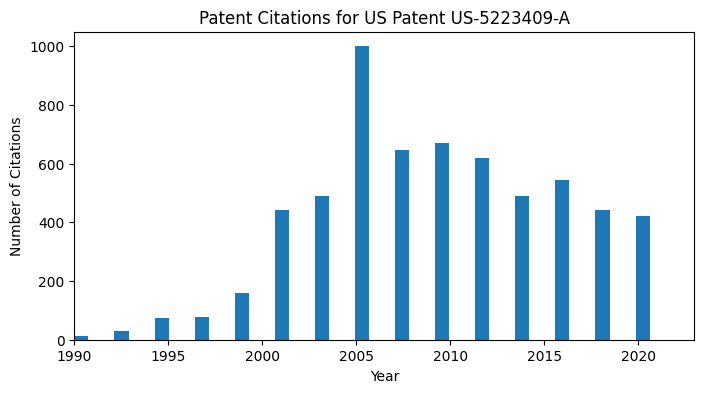

US-5530101-A


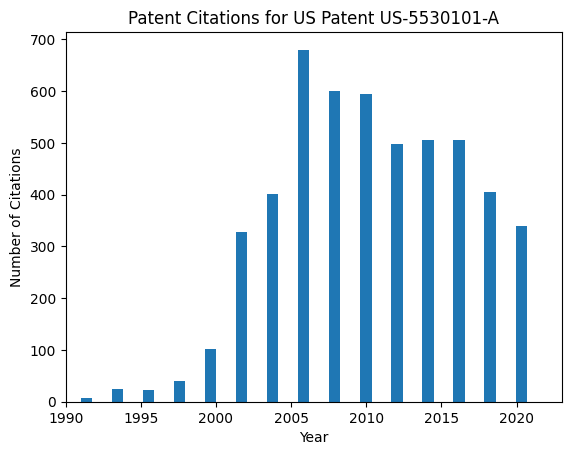

US-5569825-A


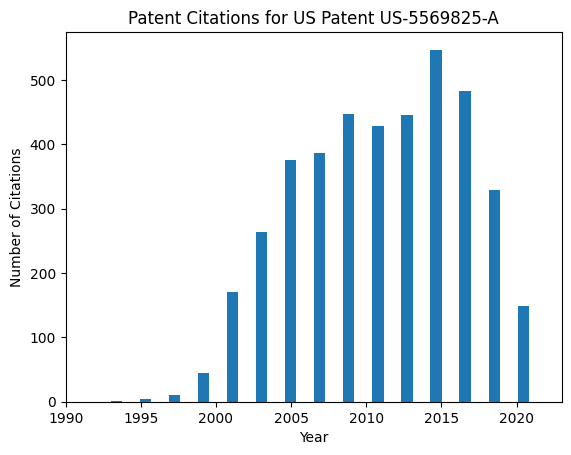

US-5143854-A


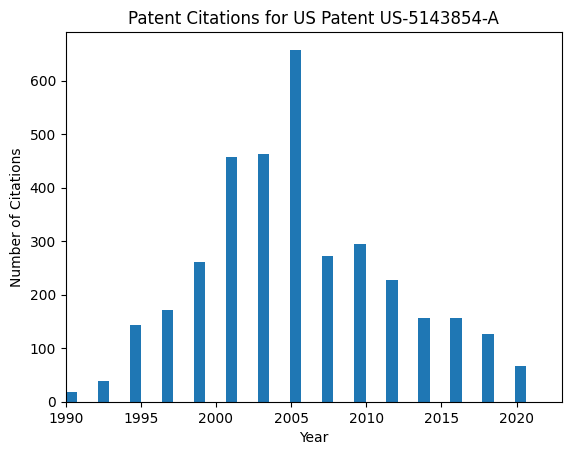

US-5247190-A


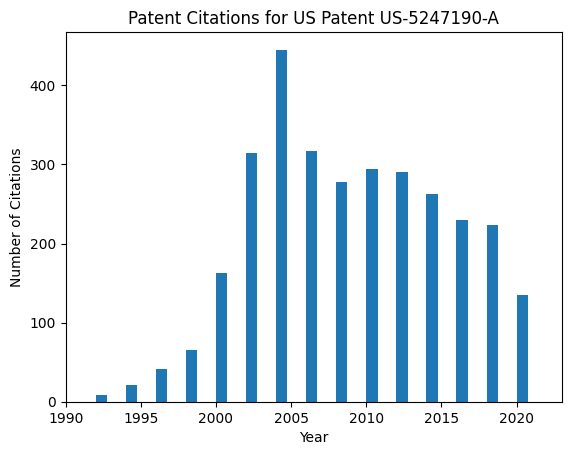

US-5103459-A


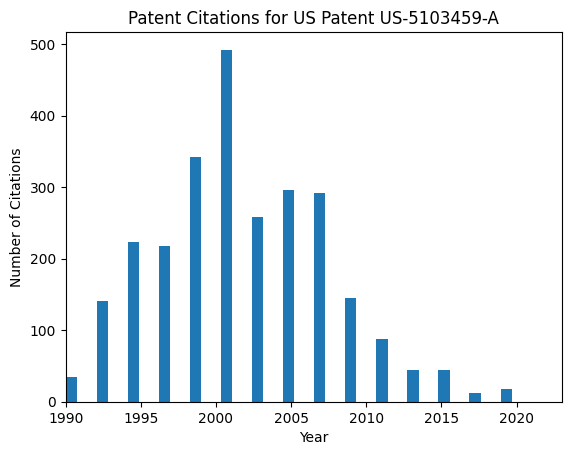

US-5103459-B1


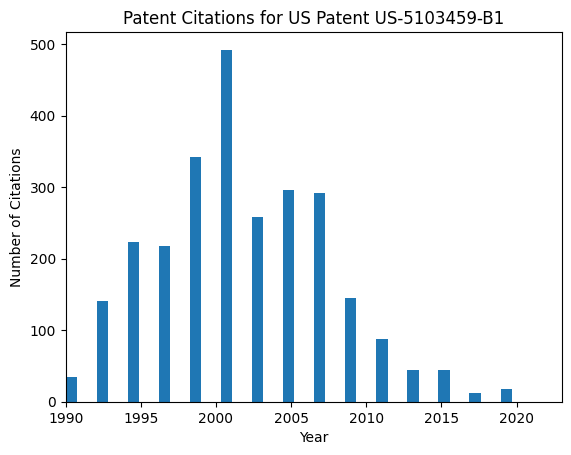

US-5272236-A


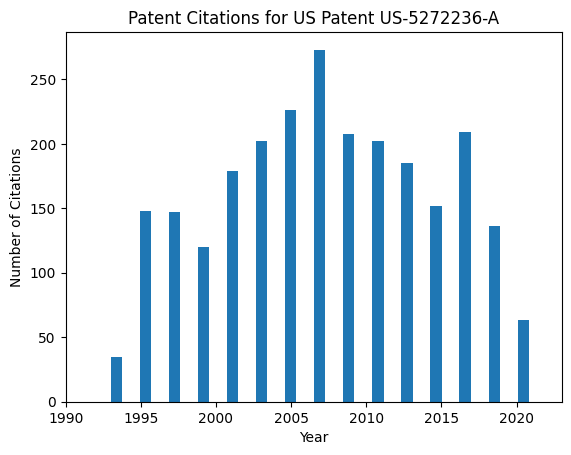

US-5969108-A


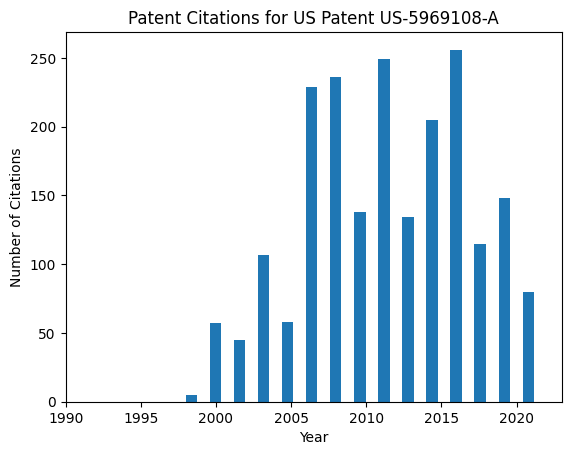

US-5192327-A


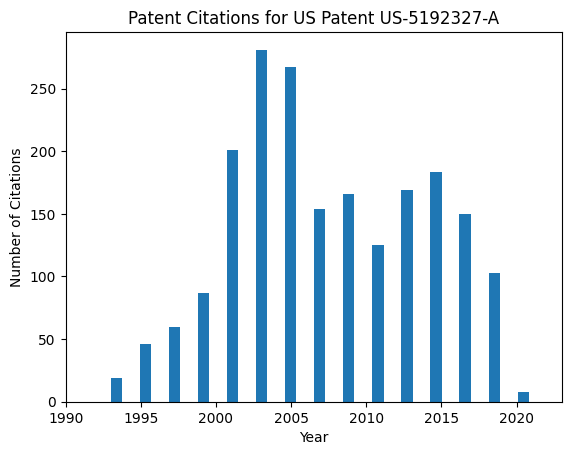

US-5145684-A


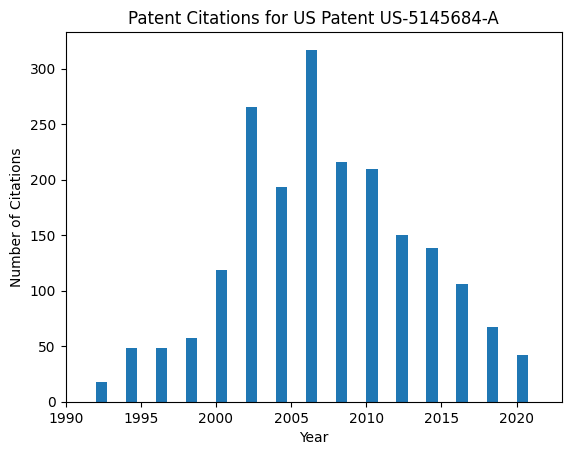

US-5210015-A


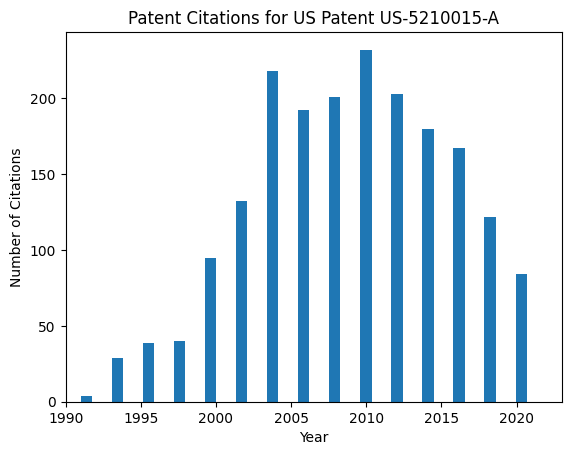

US-5151092-A


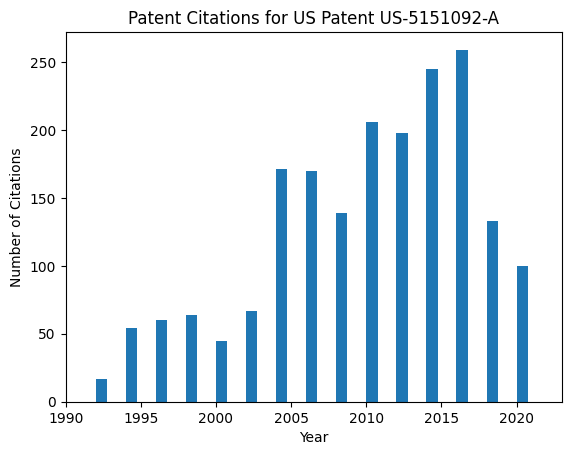

US-5064435-A


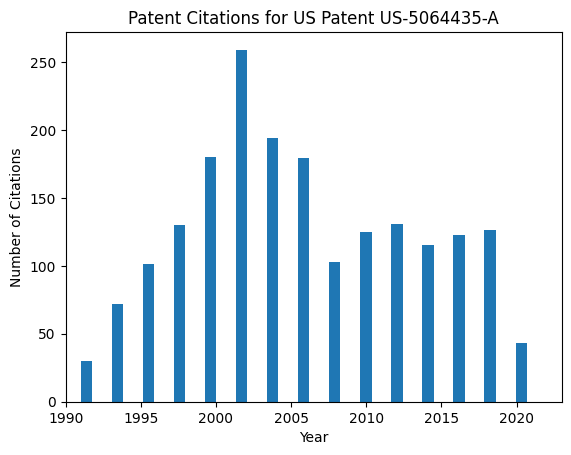

US-5192301-A


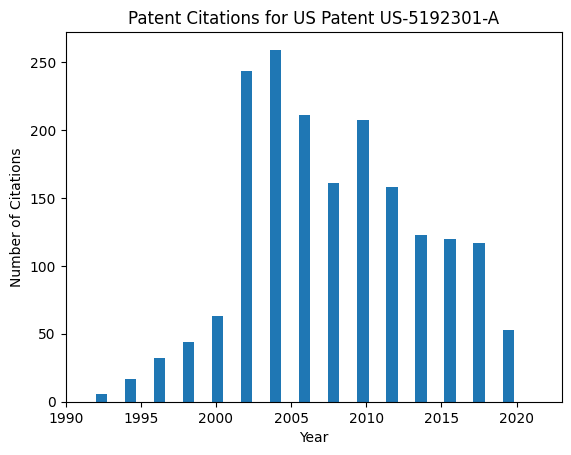

US-5645081-A


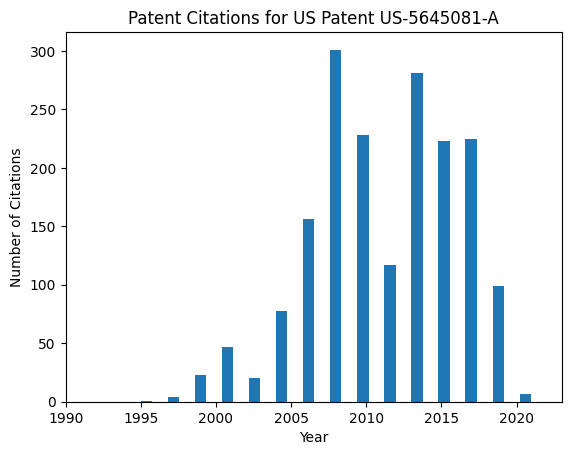

US-5429361-A


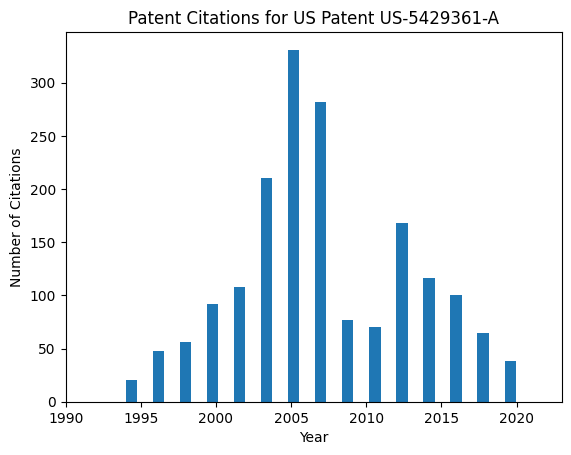

US-5297032-A


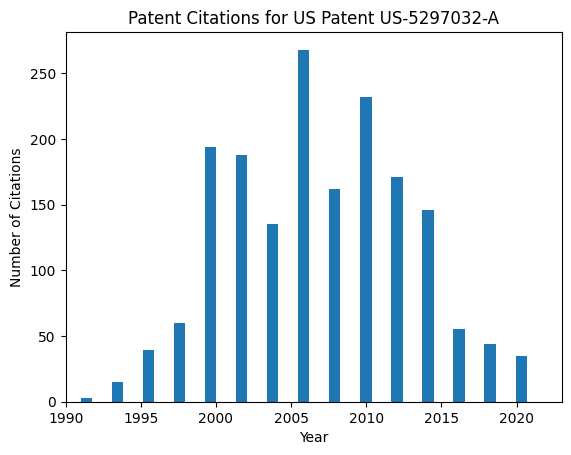

US-5172338-A


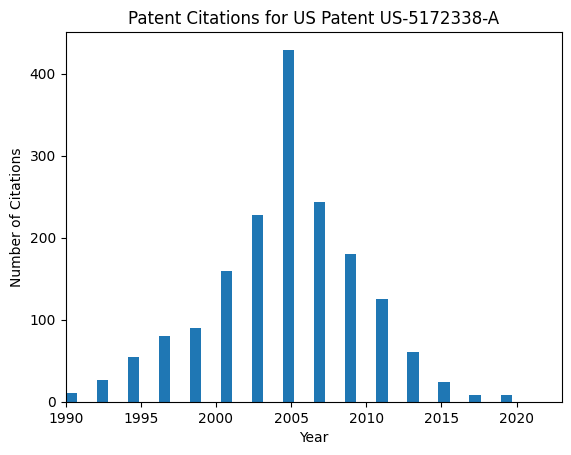

US-5172338-B1


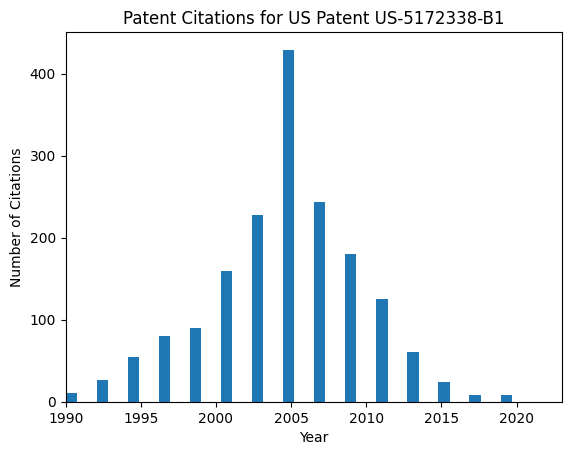

US-5304121-A


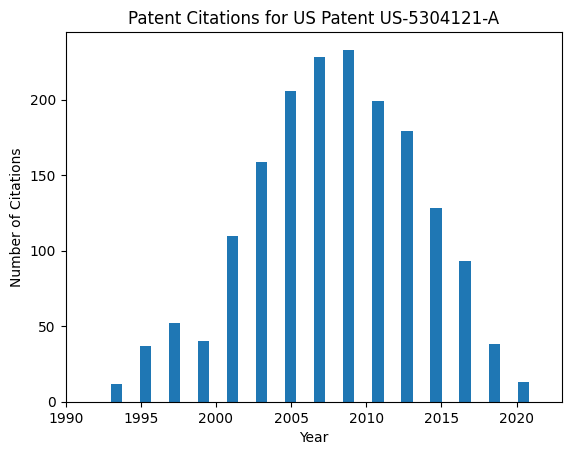

US-5279294-A


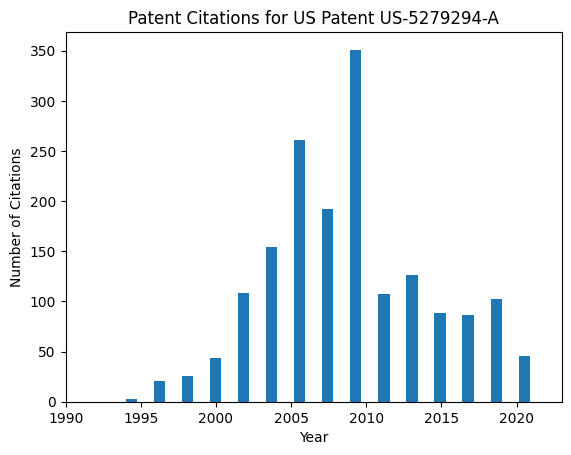

US-5059193-A


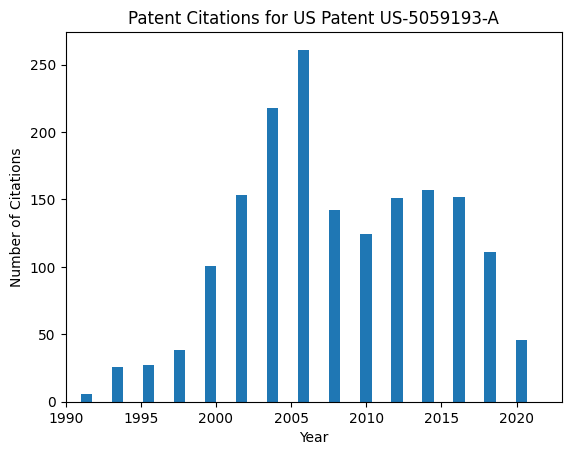

US-5297031-A


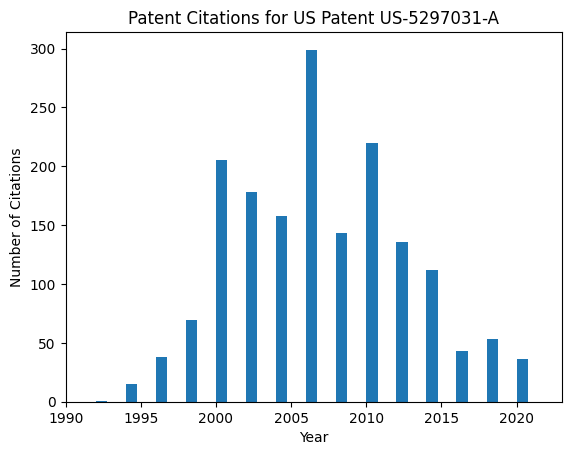

US-5092866-A


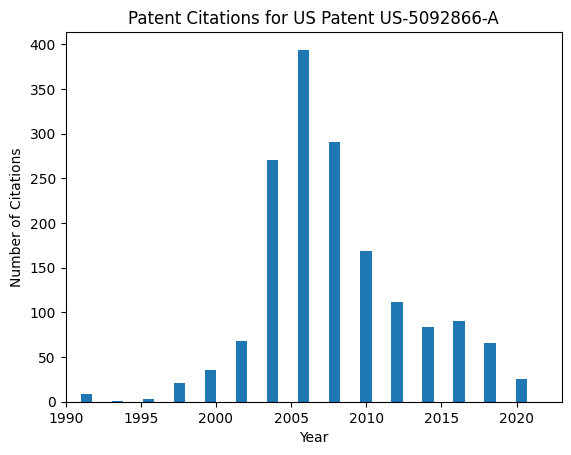

US-5424186-A


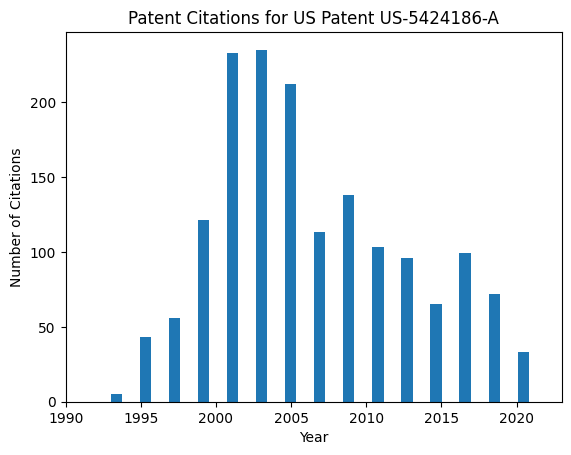

US-5165407-A


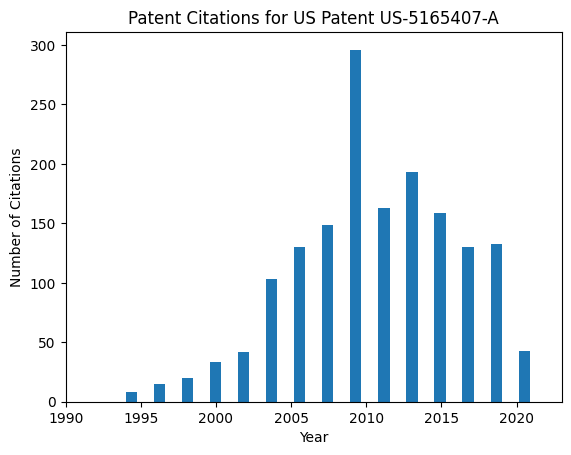

US-5432272-A


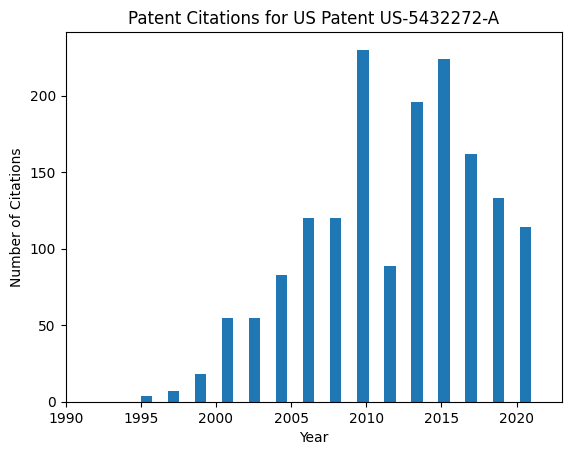

US-5100423-A


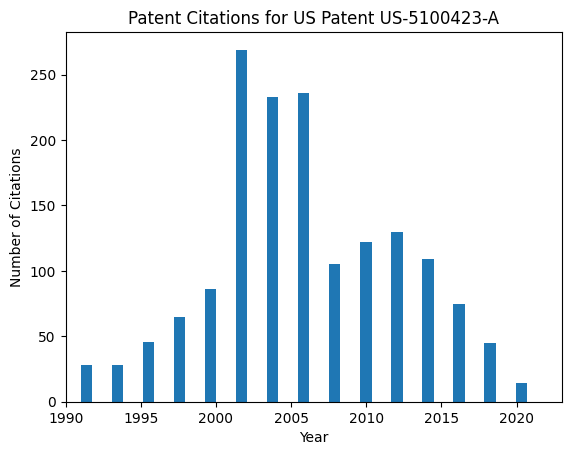

US-5108420-A


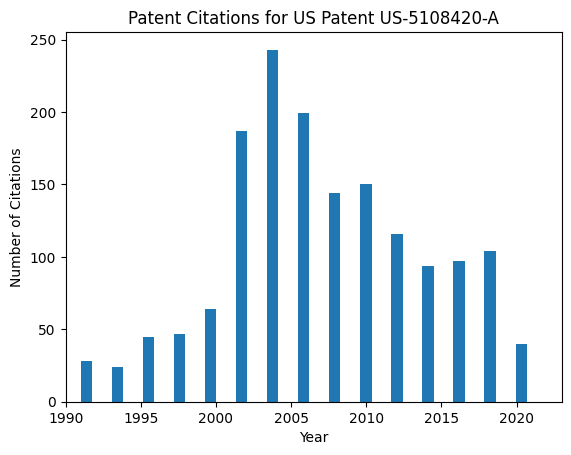

US-5370685-A


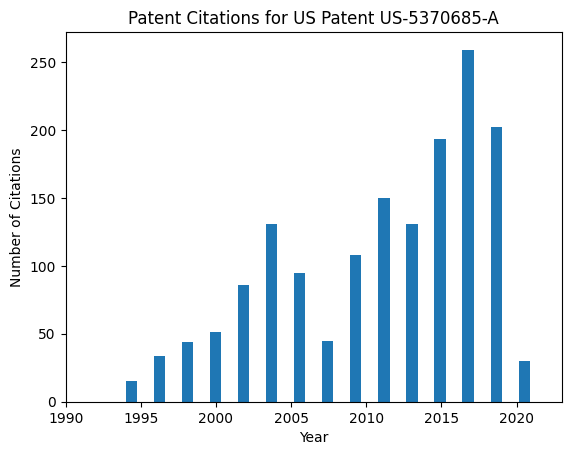

US-5354556-A


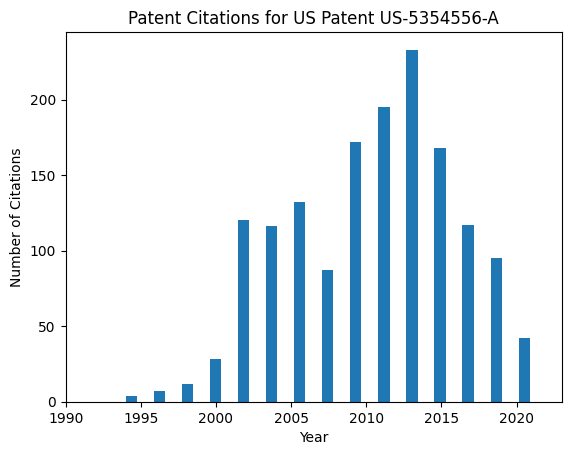

US-5335657-A


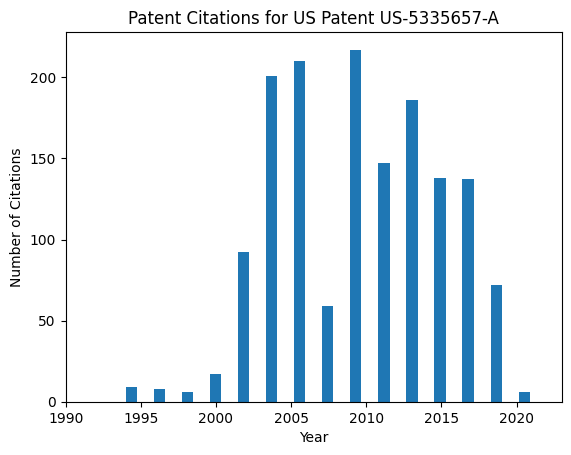

84


'\nfor i in u_labels:\n    filtered_label = clustering_unified[label == i]\n    plt.scatter(filtered_label["Time"], filtered_label["Times_90"],label = i)\nplt.title("Clustered Data comparing CPC classification codes and time taken to reach 1500 citations")\nplt.xlabel("Time until 1500 citations (years)")\nplt.ylabel("Binarized CPC Classification")\nplt.show()\n'

In [263]:
u_labels = np.unique(label)
fig = plt.figure(figsize = (8,4))
count = 0
#A graphing function of all patents must be done by two year ranges otherwise everything goes boom
#clustering_backup = pd.read_csv("1994-1996/clustering1994-1996.csv")

for i in label:
    if i == 1:
        pub_code = clustering_backup['Pub'].to_list()[count]
        print(pub_code)
        #pub_code = temp['Pub'].to_list()[newint]
        #print(pub_code)
        graph_patents(df, pub_code)
    count +=1
print(count)
"""
for i in u_labels:
    filtered_label = clustering_unified[label == i]
    plt.scatter(filtered_label["Time"], filtered_label["Times_90"],label = i)
plt.title("Clustered Data comparing CPC classification codes and time taken to reach 1500 citations")
plt.xlabel("Time until 1500 citations (years)")
plt.ylabel("Binarized CPC Classification")
plt.show()
"""